# Confusion Score Study

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

# import cs
folderpath="/beegfs/desy/user/bornemaf/data/syreal_output/example/std/cs"

files = [f for f in listdir(folderpath) if (isfile(join(folderpath, f)) and f.endswith('.csv'))]

def combine_cs(N, files, parentdir, M=0):
    DF = None
    for file in files:
        n = int(file.split('/')[-1].split('.')[0].split('_')[-1]) # extract the sample number from file name
        if n <= N and n >= M:
            df = pd.read_csv(join(parentdir,file), index_col=0).dropna(how='any')
            df['cs'] = df['cs'] / np.sum(df['cs'])
            if DF is None:
                DF = df
            else:
                DF = pd.concat([DF, df], axis=0).reset_index(drop=True)           
    return DF

In [ ]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("whitegrid")

Text(0.5, 0.98, '(I.6.2) Sampling distribution (confusion score) from N=0 to N=10')

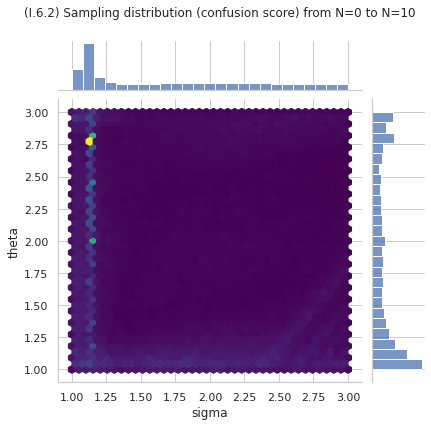

In [17]:

M=0
N=10

# load confusion score
CS = combine_cs(M=M, N=N, files=files, parentdir=folderpath)

#sample points in space based on confusion score (get distribution as histogram)
smaller_CS = CS[['sigma','theta']].sample(n=100000, weights=CS.cs, replace=True)

x = smaller_CS.sigma
y = smaller_CS.theta

joint = sns.jointplot(x=x, y=y, kind="hex", cmap="viridis", marginal_ticks=False, marginal_kws=dict(bins=25, fill=True))
joint.fig.subplots_adjust(top=.9)
joint.fig.suptitle(f"(I.6.2) Sampling distribution (confusion score) from N={M} to N={N}")

In [ ]:
from celluloid import Camera
from matplotlib import pyplot as plt

N_start = 6
N_stop = 10
delta = 5

fig = plt.figure()
camera = Camera(fig)
for i in np.arange(N_start, N_stop):
    CS = combine_cs(M=i, N=i+delta, files=files, parentdir=folderpath)
    smaller_CS = CS[['sigma','theta']].sample(n=CS.shape[0]//2, weights=CS.cs)
    x = smaller_CS.sigma
    y = smaller_CS.theta

    joint = sns.jointplot(x=x, y=y, kind="hex", cmap="viridis", marginal_ticks=False, marginal_kws=dict(bins=25, fill=True))
    joint.fig.subplots_adjust(top=.9)
    joint.fig.suptitle(f"(I.6.2) Sampling distribution (confusion score) from N={i} to N={i+delta}")
    
    camera.snap()
animation = camera.animate()
animation.save('my_animation.gif')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
%matplotlib notebook

N_start = 6
N_stop = 10
delta = 5

#select data range
def animate(i):
    CS = combine_cs(M=i+N_start, N=i+N_start+delta, files=files, parentdir=folderpath)
    smaller_CS = CS[['sigma','theta']].sample(n=CS.shape[0]//2, weights=CS.cs)
    x = smaller_CS.sigma
    y = smaller_CS.theta

    joint = sns.jointplot(x=x, y=y, kind="hex", cmap="viridis", marginal_ticks=False, marginal_kws=dict(bins=25, fill=True))
    joint.fig.subplots_adjust(top=.9)
    joint.fig.suptitle(f"(I.6.2) Sampling distribution (confusion score) from N={i+N_start} to N={i+N_start+delta}")
    
    
ani = animation.FuncAnimation(fig, animate, frames=N_stop-N_start+1,interval=700,repeat=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
import numpy as np

N_start = 6
N_stop = 10
delta = 5

def get_data(i=0):
    CS = combine_cs(M=i+N_start, N=i+N_start+delta, files=files, parentdir=folderpath)
    smaller_CS = CS[['sigma','theta']].sample(n=CS.shape[0]//2, weights=CS.cs)
    return smaller_CS.sigma, smaller_CS.theta

x,y = get_data()
g = sns.JointGrid(x=x, y=y, size=4)
lim = (1,3)

def prep_axes(g, xlim, ylim):
    g.ax_joint.clear()
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    g.ax_marg_x.clear()
    g.ax_marg_x.set_xlim(xlim)
    g.ax_marg_y.clear()
    g.ax_marg_y.set_ylim(ylim)
    plt.setp(g.ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(g.ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(g.ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(g.ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(g.ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(g.ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(g.ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(g.ax_marg_y.get_xticklabels(), visible=False)


def animate(i):
    g.x, g.y = get_data(i)
    prep_axes(g, lim, lim)
    g.plot_joint(sns.kdeplot, cmap="Purples_d")
    g.plot_marginals(sns.kdeplot, color="m", shade=True)

frames=np.sin(np.linspace(0,2*np.pi,17))*5
ani = matplotlib.animation.FuncAnimation(g.fig, animate, frames=frames, repeat=True)

plt.show()

In [19]:
import matplotlib.pyplot as plt
def make_plot(N, save=False):
    #N=34
    delta=0
    CS = combine_cs(M=N, N=N+delta, files=files, parentdir=folderpath)
    CS.cs = CS.cs / np.sum(CS.cs)
    #smaller_CS = CS[['sigma','theta']].sample(n=CS.shape[0]//2, weights=CS.cs)
    x = CS.sigma
    y = CS.theta

    H, xedges, yedges = np.histogram2d(x, y, bins=75, weights=CS.cs)
    H = H.T
    fig = plt.figure(figsize=(20, 20), dpi=100)
    ax = fig.add_subplot(131, title=f'Confusion score in N={N}')
    plt.grid(visible=False)
    plt.imshow(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap="magma" )
    if save:
        fig.savefig(f'{N}.jpg', bbox_inches = 'tight')

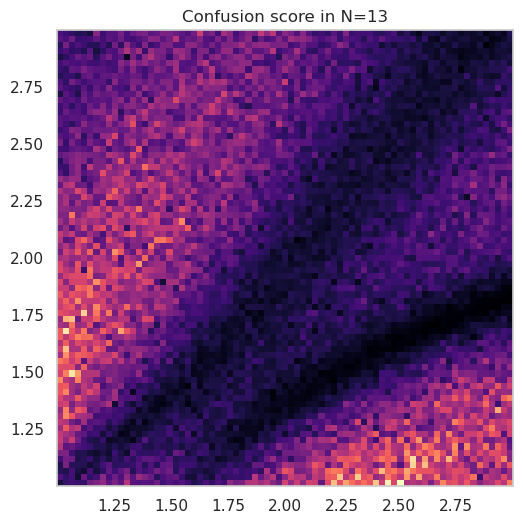

In [20]:
make_plot(13)

In [ ]:
for N in range(6,100):
    make_plot(N, save=True)

In [ ]:
#from matplotlib import animation
# Create new figure for GIF
fig, ax = plt.subplots()

# Adjust figure so GIF does not have extra whitespace
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.axis('off')
ims = []

for N in range(6,100):
    im = ax.imshow(plt.imread(f'{N}.jpg'), animated = True)
    ims.append([im])

ani = plt.animation.ArtistAnimation(fig, ims, interval=600)
ani.save('confusion_score_animation.gif')